In [1]:
# Imports
import os
import math
import random
import operator
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math, itertools
import statistics

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ShuffleSplit
from operator import itemgetter
from statistics import mean
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
# from ipynb.fs.full.helper_fns import *

In [2]:
# Helper Functions

def load_file(data_file_path):
    data_df = pd.read_csv(data_file_path, delimiter=";")
    return data_df
  
    
def plot_graph_new(results, max_calls, list_passed, title):
    x_pts = [i+1 for i in range(0, max_calls)]
    if list_passed:
        y_pts = results
    else:    
        y_pts = [results[i]['expected'] for i in range(0, max_calls)]
    plt.title(title)
    plt.plot(x_pts, y_pts)
    plt.axvline(x=0, color ="black")
    plt.axhline(y=0, color ="black")
    plt.xticks(np.arange(1, max_calls+1, 1))
    plt.show()
    

# def plot_graph_both_axes(ratios, no_calls):
    

def div(a,b):
    if int(b) == 0:
        return 0.0
    else:
        return a/b
    

# Used for creating all possible combinations of the features.
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = iterable
    return itertools.chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


def convert(list): 
    return tuple(list) 


def construct_dict(feature_comb):
    new_dict = {}
    new_dict['education'] = convert(feature_comb[0])
    new_dict['job'] = convert(feature_comb[2])
    new_dict['marital'] = convert(feature_comb[1])
    new_dict['default'] = convert(feature_comb[3])
    new_dict['loan'] = convert(feature_comb[4])
    new_dict['housing'] = convert(feature_comb[5])
    return new_dict


# This is the new metric (success per call rate).
def compute_expected_succ_per_call_rate_feature_set(fs_df, no_calls_considered):
    expected_values_call_nums = []
    for i in range(1, no_calls_considered + 1):
        expected_values_call_nums.append({'succ':0, 'total_calls':0, 'expected':0.0})
        for index, row in fs_df.iterrows():
            no_calls = row['campaign']
            if no_calls <= i:
                if row['y'] == "yes":
                    expected_values_call_nums[i-1]['succ'] += 1
                expected_values_call_nums[i-1]['total_calls'] += no_calls
            else:
                expected_values_call_nums[i-1]['total_calls'] += i
    for loc, item in enumerate(expected_values_call_nums):
        expected_values_call_nums[loc]['expected'] = div(item['succ'], item['total_calls'])
    return expected_values_call_nums


def compute_optimal_call_no(results):
    max_loc = max(range(len(results)), key=lambda index: results[index]['expected'])
    if max_loc == 0 and results[max_loc]['expected'] == 0.0:
        return -1
    return max_loc


# Given a dictionary of what attributes comprise a feature set, we can get all rows corresponding to this feature set.
def extract_rows_feature_set(fs_df, feature_labels = {'education':['tertiary', 'unknown'], 
                                                      'job':['management', 'technician', 'blue-collar'], 
                                                      'marital':['single'], 'default':['no'], 
                                                      'housing':['no'], 'loan':['no']}):
    for key in feature_labels:
        feature_labels_query_str = ''
        arr = feature_labels[key]
        for label in arr:
            feature_labels_query_str += (key + ' == "'+ label + '" | ')
        feature_labels_query_str = feature_labels_query_str[:-3]
        fs_df = fs_df.query(feature_labels_query_str)
    return fs_df


def find_matching_attribute_comb(row_value, all_combs):
    query = None
    for comb in all_combs:
        for item in comb:
            if item == row_value:
                query = comb
    return query


def find_matching_attribute_eval_age(row_value, values):
    query = None
    for index, comb in enumerate(values):
        res = comb.format(age = row_value)
        if eval(res):
            return index


def find_matching_attribute_eval_balance(row_value, values):
    query = None
    for index, comb in enumerate(values):
        res = comb.format(balance = row_value)
        if eval(res):
            return index


def compute_metric(df):
    total_calls = 0
    total_successes = 0
    for loc, row in df.iterrows():
        if row['y'] == "yes":
            total_successes += 1
        total_calls += row['campaign']
    return div(total_successes, total_calls)


def compute_metric_2(df):
    total_calls = 0
    total_successes = 0
    for loc, row in df.iterrows():
        if row['y'] == "yes":
            total_successes += 1
        total_calls += min(row['campaign'], )
    return div(total_successes, total_calls)


def compute_metric_for_each_attribute(all_values, df, attrib):
    metric_vals = np.zeros(shape=(len(all_values),1))
    for index, value in enumerate(all_values):
        v_query = "{0} == '{1}'".format(attrib, value)
        dataset_query = df.query(v_query)
        metric_val = compute_metric(dataset_query)
        metric_vals[index] = metric_val
#         print(v_query, metric_val, dataset_query.shape)
    return metric_vals


def compute_metric_for_each_attribute_range(all_values, df, attrib):
    metric_vals = np.zeros(shape=(len(all_values),1))
    query_strings = []
    for index, value in enumerate(all_values):
        v_query = "{0} >= {1} & {2} < {3}".format(attrib, value[0], attrib, value[1])
        dataset_query = df.query(v_query)
        metric_val = compute_metric(dataset_query)
        metric_vals[index] = metric_val
        query_strings.append(v_query)
#         print(v_query, metric_val, dataset_query.shape)
    return metric_vals, query_strings


def find_combinations(sub_attributes, ratios):
    num_iter = len(ratios)
    sil_scores = []
    # Making use of the K-Means algorithm ... number of centroids are from 2 to n-1.
    for clust_num in range(2, num_iter):
        kmeans = KMeans(n_clusters = clust_num)
        kmeans.fit(ratios.reshape(-1,1))
        results = kmeans.labels_
        sil_scores.append((silhouette_score(ratios.reshape(-1,1), results, metric='euclidean'), results, clust_num))
    # We make use of the silhouette score to determine the ideal number of centroids.
    sorted_sil_scores = sorted(sil_scores, key=lambda x: x[0], reverse = True)
    # We then use this ideal number of centroids to determine which sub attributes should be aggregated.
    joined_sub_attributes = []
    for i in range(0, sorted_sil_scores[0][2]):
        joined_sub_attributes.append([])
    join_list = sorted_sil_scores[0][1]
    for index, value in enumerate(join_list):
        pos = join_list[index]
        joined_sub_attributes[pos].append(sub_attributes[index])
    return_joined_sub_attributes = []
    for arr in joined_sub_attributes:
        similar_els_gp = []
        for item in arr:
            similar_els_gp.append(str(item))
        return_joined_sub_attributes.append(similar_els_gp)
#     print(return_joined_sub_attributes)
    return return_joined_sub_attributes

# The following is the format of the way in which this method should be called.
# find_combinations(['a', 'b', 'c', 'd'], np.array([1, 4, 7, 90]), "job").


def find_all_cust_feature_set(fs, df):
    comb = {
        'education':fs[0], 
         'job':fs[1], 
         'marital':fs[2], 
         'default':fs[3], 
         'loan':fs[4], 
         'housing':fs[5]
    }
    res_1 = df.query(fs[6])
    res_2 = res_1.query(fs[7])
    res_final = extract_rows_feature_set(res_2, comb)
    return res_final

In [4]:
%%time
# Code that sets up values to construct all possible feature combinations.

# Age query strings.
# age_query_strings = ['age < 26','age >= 26 & age <=60','age >60']
# age_query_strings = ['age >= 10 & age <= 32', 'age >= 33 & age <= 40', 'age >= 50 & age <= 59', 'age >= 60']

# These strings are used for queries.
age_query_strings = ['age >= 10 & age <= 34', 'age >= 35 & age <= 45', 'age >= 46']
balance_query_strings = ['balance <= 450','balance > 450']

# These strings are used for injecting values into the statement when using eval.
age_query_format_strings = ['{age} >= 10 and {age} <= 34', '{age} >= 35 and {age} <= 45', '{age} >= 46']
balance_query_format_strings = ['{balance} <= 450','{balance} > 450']

# Max call number to consider.
max_calls = 20

# Pull and filter all calls <= 20.
current_dir = os.getcwd()
mkt_df = load_file(current_dir + '/bank-full.csv')
mkt_df_filtered = mkt_df[(mkt_df['campaign']>=1) & (mkt_df['campaign']<=max_calls)]

print(mkt_df_filtered.shape)

(44967, 17)
CPU times: user 73.6 ms, sys: 17.9 ms, total: 91.5 ms
Wall time: 90.3 ms


In [5]:
%%time

baseline_ov = []
opt_no_res_ov = []
opt_res_ov = []

train_df = mkt_df_filtered
test_df = mkt_df_filtered

# At this point, we can run computations for the success rate of each sub attribute and join
# the sub-attributes based on the output of k-means.
poss = []

# Education
all_ed = ['tertiary', 'secondary', 'primary', 'unknown']
metric_vals = compute_metric_for_each_attribute(all_ed, train_df, 'education')
education_cmbs = find_combinations(all_ed, metric_vals)

# Occupation
all_jobs = ['student', 'retired', 'unemployed', 'admin.', 'management', 'self-employed', 'technician', 'unknown', 'services', 'housemaid', 'blue-collar', 'entrepreneur']
metric_vals = compute_metric_for_each_attribute(all_jobs, train_df, 'job')
job_cmbs = find_combinations(all_jobs, metric_vals)

# Marital
all_ms = ['married', 'single', 'divorced', 'unknown']
metric_vals = compute_metric_for_each_attribute(all_ms, train_df, 'marital')
marital_cmbs = find_combinations(all_ms, metric_vals)

# Default
all_def = ['no', 'yes', 'unknown']
metric_vals = compute_metric_for_each_attribute(all_def, train_df, 'default')
default_cmbs = find_combinations(all_def, metric_vals)

# Loan
all_ln = ['no', 'yes', 'unknown']
metric_vals = compute_metric_for_each_attribute(all_ln, train_df, 'loan')
loan_cmbs = find_combinations(all_ln, metric_vals)

# Housing
all_hs = ['no', 'yes', 'unknown']
metric_vals = compute_metric_for_each_attribute(all_hs, train_df, 'housing')
housing_cmbs = find_combinations(all_hs, metric_vals)

poss.append(education_cmbs)
poss.append(marital_cmbs)
poss.append(job_cmbs)
poss.append(default_cmbs)
poss.append(loan_cmbs)
poss.append(housing_cmbs)
all_combs = list(itertools.product(*poss))

print("Number of combinations: ", len(all_combs)* len(age_query_strings) * len(balance_query_strings))

# We can now go ahead and genreate the feature sets based on what was done previously.

num_iter = 0
combs_to_consider = {}
fs_pick = {}
max_rows = 0
max_rows_fs = None
# Setting up looping structures to generate all possibilities.
# All that has to be done now is to change 'df_train' to 'X_train'.
for age_query in age_query_strings:
    df_filtered_final = train_df.query(age_query)
    for bal_query in balance_query_strings:
        df_filtered_final_2 = df_filtered_final.query(bal_query)
        for comb in all_combs:
            dict_final_query = construct_dict(comb)
            num_iter += 1
            extracted_df = extract_rows_feature_set(df_filtered_final_2, dict_final_query)
            key = (dict_final_query['education'], dict_final_query['job'], dict_final_query['marital'], dict_final_query['default'], dict_final_query['loan'], dict_final_query['housing'], age_query, bal_query)
            n_rows = extracted_df.shape[0]
            if n_rows > 0:
                if n_rows > max_rows:
                    n_rows = max_rows
                    max_rows_fs = key
                results = compute_expected_succ_per_call_rate_feature_set(extracted_df, max_calls)
                max_loc = compute_optimal_call_no(results)
                if max_loc != -1:
                    combs_to_consider[key] = {
                                                'max_loc':max_loc + 1,
                                                'curr_loc':-1,
                                                'best_rate':results[max_loc]['expected'], 
                                                'overall_rate':results[max_calls-1]['expected'], 
                                                'n_rows':n_rows, 
                                                'results':results,
                                                'fs_customers':extracted_df
                                             }
                    fs_pick[key] = {'current_ratio': 0.0, 'call_num':0, 'finished':False}
#                 else:
#                     print("Invalid FS !")

Number of combinations:  384
CPU times: user 1min 51s, sys: 154 ms, total: 1min 51s
Wall time: 1min 51s


In [ ]:
print(max_rows)
print(max_rows_fs)
plot_graph_new(combs_to_call[max_rows_fs]['results'], max_calls, False, "Expected Ratio per Call")

In [6]:
# Find all customers for each feature set and assign them! ... This can be removed if everything is matching up.

for fs_key in combs_to_consider.keys():
    fs_customers = find_all_cust_feature_set(fs_key, test_df)
    if len(fs_customers) != len(combs_to_consider[fs_key]['fs_customers']):
        print("Error!")

In [7]:
persons_to_call_overall = {k: v for k, v in sorted(combs_to_consider.items(), key=lambda fs: fs[1]['overall_rate'], reverse = True)}

num_succ = 0
num_calls = 0
num_fs = 0
print(type(persons_to_call_overall))
result_ratios = []
for key in persons_to_call_overall.keys():
    num_fs += 1
    for loc, cust in persons_to_call_overall[key]['fs_customers'].iterrows():
        num_calls += cust['campaign']
        if cust['y'] == "yes":
            num_succ +=1
#     c = {"fs":1, "num_s":num_succ, "num_c":num_calls, "fs_ratio":0}
#     result_ratios.append(c)
#     print((div(num_succ,num_calls)))
    result_ratios.append((div(num_succ,num_calls), num_fs))
print(result_ratios)

<class 'dict'>
[(0.25, 1), (0.2222222222222222, 2), (0.1949367088607595, 3), (0.19123020706455543, 4), (0.19098457888493475, 5), (0.19081272084805653, 6), (0.1837686567164179, 7), (0.18230563002680966, 8), (0.1735191637630662, 9), (0.15384615384615385, 10), (0.1514155712841254, 11), (0.1508503820557062, 12), (0.15079950799507996, 13), (0.14811407543698252, 14), (0.12811071609954292, 15), (0.11912976806593828, 16), (0.1190180533002197, 17), (0.10712785324184287, 18), (0.10477738056548587, 19), (0.09847572154418312, 20), (0.09845590159644073, 21), (0.09767465683261627, 22), (0.09749261033533789, 23), (0.09745913743062275, 24), (0.09163712747800971, 25), (0.09144350097975179, 26), (0.08248722316865417, 27), (0.07853702588801927, 28), (0.07510735337262955, 29), (0.07291870714985309, 30), (0.07098982297876198, 31), (0.06935328701229289, 32), (0.06702396962265643, 33), (0.06700796584372715, 34), (0.06522749669957792, 35), (0.06405179794520548, 36), (0.06396941134625644, 37), (0.0639121097563

In [9]:
persons_to_call_max = {k: v for k, v in sorted(combs_to_consider.items(), key=lambda fs: fs[1]['best_rate'], reverse = True)}

num_succ = 0
num_calls = 0
num_fs = 0
good = 0
print(type(persons_to_call_max))
result_ratios = []
for key in persons_to_call_max.keys():
    num_fs += 1
    max_calls_fs = persons_to_call_max[key]['max_loc']
    for loc, cust in persons_to_call_max[key]['fs_customers'].iterrows():
        cust_calls = cust['campaign']
        if cust_calls <= max_calls_fs:
            num_calls += cust_calls
            if cust['y'] == "yes":
                num_succ +=1
        else:
            num_calls += max_calls_fs
    result_ratios.append((div(num_succ, num_calls), num_calls))
#     print(div(num_succ, num_calls))
#     print(persons_to_call_max[key]['best_rate'])
    if div(num_succ, num_calls) >= persons_to_call_max[key]['overall_rate']:
        good += 1
#     num_succ = 0
#     num_calls = 0
print(result_ratios)
print(good)
print(len(persons_to_call_max.keys()))

<class 'dict'>
[(0.2608695652173913, 23), (0.25925925925925924, 27), (0.25806451612903225, 31), (0.22580645161290322, 217), (0.2219626168224299, 428), (0.22170900692840648, 433), (0.22121896162528218, 443), (0.22098214285714285, 448), (0.22075055187637968, 453), (0.18479087452471482, 1315), (0.18328651685393257, 1424), (0.18123803446075304, 1567), (0.17378780604896785, 2083), (0.1721014492753623, 2208), (0.17079530638852672, 2301), (0.15425888665325285, 4473), (0.15198863636363635, 4928), (0.1519448946515397, 4936), (0.15190129449838188, 4944), (0.14626865671641792, 6030), (0.14601550899191554, 6061), (0.1369714980413346, 7403), (0.1300422808821849, 8751), (0.128429203539823, 9040), (0.12813462384513857, 9092), (0.12774320340648543, 9159), (0.11845454545454545, 11000), (0.11204905630325715, 12557), (0.10503208375548802, 14805), (0.10062627965795495, 16606), (0.10047387679203407, 16671), (0.09517573725839401, 19091), (0.09502687470646559, 19163), (0.09206901551399159, 20691), (0.0874038

In [36]:
points = []
total_s = 0
total_c = 0

for i in range(1,22):

    for key in combs_to_consider.keys():
        fs_ref = combs_to_consider[key]['results']
        pos = fs_pick[key]['call_num']
        if pos < 20:
            fs_pick[key]['call_num'] += 1
            if pos == 0:
                fs_pick[key]['current_ratio'] = div(fs_ref[pos]['succ'], fs_ref[pos]['total_calls'])
            else:
                fs_pick[key]['current_ratio'] = div(fs_ref[pos]['succ'] - fs_ref[pos-1]['succ'], fs_ref[pos]['total_calls'] - fs_ref[pos-1]['total_calls'])
#             fs_pick[key]['current_ratio'] = combs_to_consider[key]['results'][pos]['expected']
        else:
            fs_pick[key]['finished'] = True

    optimal_choices = {k: v for k, v in sorted(fs_pick.items(), key=lambda val: val[1]['current_ratio'], reverse = True)}

    for key in optimal_choices.keys():
        if optimal_choices[key]['finished'] == False:
            for loc, row in combs_to_consider[key]['fs_customers'].iterrows():
                if row['campaign'] == (fs_pick[key]['call_num']):
                    total_c += row['campaign']
                    if row['y'] == "yes":
                        total_s += 1
            points.append((div(total_s, total_c), total_c))
            
# print("Finished! :)")
# for pt in points:
#     print(pt[1], pt[0])

print(points)

[(0.46153846153846156, 13), (0.4375, 16), (0.42857142857142855, 112), (0.41964285714285715, 224), (0.4185022026431718, 227), (0.4199134199134199, 231), (0.41702127659574467, 235), (0.4194915254237288, 236), (0.38596491228070173, 627), (0.38404726735598227, 677), (0.37986577181208053, 745), (0.37484433374844334, 803), (0.3702081051478642, 913), (0.36663124335812963, 941), (0.352234823215477, 1499), (0.34488836662749706, 1702), (0.3448680351906158, 1705), (0.3269668030923147, 2199), (0.3161819537658464, 2682), (0.3074976273331224, 3161), (0.30624411672419205, 3187), (0.30275229357798167, 3270), (0.2905680891546616, 3679), (0.2758053138960734, 4253), (0.2635148613604628, 5013), (0.2628968253968254, 5040), (0.2592038871239021, 5351), (0.25890692035068086, 5361), (0.2588804165891761, 5377), (0.24677932072946293, 5977), (0.24317855433221638, 6267), (0.23238206173558532, 6868), (0.22396672034353193, 7452), (0.21784744507529005, 8102), (0.217584041374215, 8121), (0.21743942934448407, 8131), (0

In [33]:
for key in optimal_choices.keys():
    print(fs_pick[key]['finished'])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [35]:
for key in fs_pick.keys():
    fs_pick[key]['call_num'] = 0
    fs_pick[key]['finished'] = False
    fs_pick[key]['current_ratio'] = 0.0

In [34]:
for key in combs_to_consider.keys():
    print(combs_to_consider[key]['results'])
    print("\n\n")

[{'succ': 0, 'total_calls': 38, 'expected': 0.0}, {'succ': 3, 'total_calls': 66, 'expected': 0.045454545454545456}, {'succ': 3, 'total_calls': 82, 'expected': 0.036585365853658534}, {'succ': 3, 'total_calls': 91, 'expected': 0.03296703296703297}, {'succ': 3, 'total_calls': 95, 'expected': 0.031578947368421054}, {'succ': 3, 'total_calls': 98, 'expected': 0.030612244897959183}, {'succ': 3, 'total_calls': 100, 'expected': 0.03}, {'succ': 3, 'total_calls': 102, 'expected': 0.029411764705882353}, {'succ': 3, 'total_calls': 104, 'expected': 0.028846153846153848}, {'succ': 3, 'total_calls': 106, 'expected': 0.02830188679245283}, {'succ': 3, 'total_calls': 108, 'expected': 0.027777777777777776}, {'succ': 3, 'total_calls': 110, 'expected': 0.02727272727272727}, {'succ': 3, 'total_calls': 112, 'expected': 0.026785714285714284}, {'succ': 3, 'total_calls': 114, 'expected': 0.02631578947368421}, {'succ': 3, 'total_calls': 116, 'expected': 0.02586206896551724}, {'succ': 3, 'total_calls': 118, 'expec

In [ ]:
# Can potentially scrap the code after this point .... 

In [102]:
def inc_increase(fs_key, call_point):
    fs_ref = combs_to_consider[fs_key]
    if fs_ref['curr_loc'] != -1:
        loc = fs_ref['curr_loc']
    else:
        loc = call_point
    change_s = 0
    change_c = 0
    increase = 0.0
    while(increase == 0.0 and loc<=18):
        change_s = fs_ref['results'][loc+1]['succ'] - fs_ref['results'][loc]['succ']
        change_c = fs_ref['results'][loc+1]['total_calls'] - fs_ref['results'][loc]['total_calls']
        increase = div(change_s, change_c)
        loc += 1
    combs_to_consider[fs_key]['curr_loc'] = loc
    return increase

In [117]:
for key in combs_to_consider.keys():
    optimal_call_point = combs_to_consider[key]['max_loc']
    combs_to_consider[key]['curr_loc'] = optimal_call_point - 1
    ratio = div(combs_to_consider[key]['results'][optimal_call_point-1]['succ'], combs_to_consider[key]['results'][optimal_call_point-1]['total_calls'])
    fs_pick[key]['current_ratio'] = ratio

In [119]:
inc_increase_all_fs = {k: v for k, v in sorted(fs_pick.items(), key=lambda val: val[1]['current_ratio'], reverse = True)}
for key in inc_increase_all_fs.keys():
#     print(inc_increase_all_fs[key], combs_to_consider[key]['curr_loc'], key, combs_to_consider[key]['results'])
#     break
    print(inc_increase_all_fs[key], combs_to_consider[key]['curr_loc'])

{'current_ratio': 0.2608695652173913} 0
{'current_ratio': 0.25} 0
{'current_ratio': 0.25} 3
{'current_ratio': 0.22043010752688172} 0
{'current_ratio': 0.21800947867298578} 0
{'current_ratio': 0.2} 0
{'current_ratio': 0.2} 0
{'current_ratio': 0.2} 0
{'current_ratio': 0.2} 0
{'current_ratio': 0.16589327146171692} 0
{'current_ratio': 0.1651376146788991} 0
{'current_ratio': 0.16083916083916083} 0
{'current_ratio': 0.1511627906976744} 3
{'current_ratio': 0.144} 0
{'current_ratio': 0.13978494623655913} 3
{'current_ratio': 0.13674033149171272} 1
{'current_ratio': 0.12967032967032968} 0
{'current_ratio': 0.125} 2
{'current_ratio': 0.125} 0
{'current_ratio': 0.12062615101289134} 0
{'current_ratio': 0.0967741935483871} 2
{'current_ratio': 0.09612518628912071} 0
{'current_ratio': 0.09198813056379822} 0
{'current_ratio': 0.07958477508650519} 1
{'current_ratio': 0.07692307692307693} 0
{'current_ratio': 0.07462686567164178} 1
{'current_ratio': 0.07224334600760456} 1
{'current_ratio': 0.0667951188182

In [123]:
total_succ = 0
total_calls = 0
s_r_overall = []
for key in inc_increase_all_fs.keys():
    fs_ref = combs_to_consider[key]
    loc = fs_ref['curr_loc'] - 1
    total_succ += (fs_ref['results'][loc+1]['succ'])
    total_calls += (fs_ref['results'][loc+1]['total_calls'])
    s_r = div(total_succ,total_calls)
    s_r_overall.append((s_r, total_calls))

In [124]:
print(s_r_overall)

[(0.2608695652173913, 23), (0.25925925925925924, 27), (0.25806451612903225, 31), (0.22580645161290322, 217), (0.2219626168224299, 428), (0.22170900692840648, 433), (0.22146118721461186, 438), (0.22098214285714285, 448), (0.22075055187637968, 453), (0.18479087452471482, 1315), (0.18328651685393257, 1424), (0.18123803446075304, 1567), (0.17378780604896785, 2083), (0.1721014492753623, 2208), (0.17079530638852672, 2301), (0.15425888665325285, 4473), (0.15198863636363635, 4928), (0.1519448946515397, 4936), (0.15190129449838188, 4944), (0.14626865671641792, 6030), (0.14601550899191554, 6061), (0.1369714980413346, 7403), (0.1300422808821849, 8751), (0.128429203539823, 9040), (0.12813462384513857, 9092), (0.12774320340648543, 9159), (0.11845454545454545, 11000), (0.11204905630325715, 12557), (0.10503208375548802, 14805), (0.10062627965795495, 16606), (0.10047387679203407, 16671), (0.09517573725839401, 19091), (0.09502687470646559, 19163), (0.09206901551399159, 20691), (0.08740381754027973, 235

In [122]:
for i, item in enumerate(all_possible_calls_sorted_overall):
    if item[5] == (('secondary', 'primary'), ('student', 'retired'), ('married', 'single', 'divorced'), ('no',), ('no', 'yes'), ('no',), 'age >= 35 & age <= 45', 'balance > 450'):
        print(i, item[2])

44513 no
44517 no
44519 no
44522 no
44525 no
44526 no
44527 no
44528 no
44529 no
44530 no
44531 no
44532 no
44533 no
44534 no
44535 no
44541 yes
44547 no
44548 no
44549 no
44553 no
44554 no
44555 no


In [121]:
import json

# Baseline with shuffling of customers.
# call_check_points = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500, 18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000, 22500, 23000, 23500, 24000, 24500, 25000, 25500, 26000, 26500, 27000, 27500, 28000, 28500, 29000, 29500, 30000, 30500, 31000, 31500, 32000, 32500, 33000, 33500, 34000, 34500, 35000, 35500, 36000, 36500, 37000, 37500, 38000, 38500, 39000, 39500, 40000, 40500, 41000, 41500, 42000, 42500, 43000, 43500, 44000, 44500, 45000, 45500, 46000, 46500, 47000, 47500, 48000, 48500, 49000, 49500, 50000, 50500, 51000, 51500, 52000, 52500, 53000, 53500, 54000, 54500, 55000, 55500, 56000, 56500, 57000, 57500, 58000, 58500, 59000, 59500, 60000, 60500, 61000, 61500, 62000, 62500, 63000, 63500, 64000, 64500, 65000, 65500, 66000, 66500, 67000, 67500, 68000, 68500, 69000, 69500, 70000, 70500, 71000, 71500, 72000, 72500, 73000, 73500, 74000, 74500, 75000, 75500, 76000, 76500, 77000, 77500, 78000, 78500, 79000, 79500, 80000, 80500, 81000, 81500, 82000, 82500, 83000, 83500, 84000, 84500, 85000, 85500, 86000, 86500, 87000, 87500, 88000, 88500, 89000, 89500, 90000, 90500, 91000, 91500, 92000, 92500, 93000, 93500, 94000, 94500, 95000, 95500, 96000, 96500, 97000, 97500, 98000, 98500, 99000, 99500, 100000, 100500, 101000, 101500, 102000, 102500, 103000, 103500, 104000, 104500, 105000, 105500, 106000, 106500, 107000, 107500, 108000, 108500, 109000, 109500, 110000, 110500, 111000, 111500, 112000, 112500, 113000, 113500, 114000, 114500, 115000, 115500, 116000, 116500, 117000, 117500, 118000, 118500, 119000, 119500, 120000, 120500, 121000, 121500, 122000, 122500, 123000, 123500, 124000, 124500, 125000, 125500, 126000, 126500, 127000, 127500, 128000, 128500, 129000, 129500, 130000, 130500, 131000, 131500, 132000, 132500, 133000, 133500, 134000, 134500, 135000, 135500, 136000, 136500, 137000, 137500, 138000, 138500, 139000, 139500]
# s_c_ratio_baseline_cp = []
# num_succ = 0
# num_calls = 0
# cp_loc = 0
# res = test_df.reindex(np.random.permutation(test_df.index))
# for loc, row in res.iterrows():
#     if num_calls >= call_check_points[cp_loc]:
#         cp_loc += 1
#         s_c_ratio_baseline_cp.append(div(num_succ, num_calls))
#     num_calls += row['campaign']
#     if row['y'] == "yes":
#         num_succ += 1
# s_c_ratio_baseline_cp.append(div(num_succ, num_calls))

# Optimal with no restrictions on #calls for each feature set.
all_possible_calls_sorted_overall = sorted(all_possible_calls, key = lambda tup: float(tup[1]), reverse = True)
s_c_ratio_opt_no_res = []
num_calls_overall = 0
num_succ_overall = 0
num_calls = 0
num_succ = 0
num_fs = 0

prev_fs = all_possible_calls_sorted_overall[0][5]
print(prev_fs)
for index, item in enumerate(all_possible_calls_sorted_overall):
    if prev_fs != item[5]:
        num_fs += 1
        current_ratio = div(num_succ, num_calls)
        overall_ratio = div(num_succ_overall, num_calls_overall)
#         s_c_ratio_opt_no_res.append((div(num_succ_overall, num_calls_overall), num_calls_overall))
        print(num_fs, prev_fs, combs_to_consider[prev_fs]['overall_rate'], num_calls, num_succ , current_ratio)
        print("\n")
#         add_tod = {'fs':num_fs, 'num_s':num_succ, 'num_c':num_calls, 'fs_ratio':current_ratio}
#         my_d.append(add_tod)
        num_calls = 0
        num_succ = 0
    prev_fs = item[5]
    num_calls_overall += item[3]
    num_calls += item[3]
    if item[2] == "yes":
        num_succ_overall += 1
        num_succ += 1
# s_c_ratio_opt_no_res.append(((div(num_succ, num_calls), num_calls)))
# print(json.dumps(my_d))

(('tertiary', 'unknown'), ('student', 'retired'), ('married', 'single', 'divorced'), ('yes', 'unknown'), ('no', 'yes'), ('yes', 'unknown'), 'age >= 46', 'balance > 450')
1 (('tertiary', 'unknown'), ('student', 'retired'), ('married', 'single', 'divorced'), ('yes', 'unknown'), ('no', 'yes'), ('yes', 'unknown'), 'age >= 46', 'balance > 450') 0.25 4 1 0.25


2 (('tertiary', 'unknown'), ('unemployed', 'admin.', 'management', 'self-employed', 'technician', 'unknown', 'services', 'housemaid', 'blue-collar', 'entrepreneur'), ('married', 'single', 'divorced'), ('yes', 'unknown'), ('no', 'yes'), ('yes', 'unknown'), 'age >= 10 & age <= 34', 'balance > 450') 0.2 5 1 0.2


3 (('secondary', 'primary'), ('student', 'retired'), ('married', 'single', 'divorced'), ('no',), ('no', 'yes'), ('no',), 'age >= 10 & age <= 34', 'balance <= 450') 0.19430051813471502 386 75 0.19430051813471502


4 (('secondary', 'primary'), ('student', 'retired'), ('married', 'single', 'divorced'), ('no',), ('no', 'yes'), ('no'

In [109]:
combs_to_consider[(('secondary', 'primary'), ('student', 'retired'), ('married', 'single', 'divorced'), ('no',), ('no', 'yes'), ('no',), 'age >= 35 & age <= 45', 'balance > 450')]

{'max_loc': 1,
 'best_rate': 0.045454545454545456,
 'overall_rate': 0.016129032258064516,
 'n_rows': 22,
 'results': [{'succ': 1, 'total_calls': 22, 'expected': 0.045454545454545456},
  {'succ': 1, 'total_calls': 34, 'expected': 0.029411764705882353},
  {'succ': 1, 'total_calls': 42, 'expected': 0.023809523809523808},
  {'succ': 1, 'total_calls': 48, 'expected': 0.020833333333333332},
  {'succ': 1, 'total_calls': 53, 'expected': 0.018867924528301886},
  {'succ': 1, 'total_calls': 56, 'expected': 0.017857142857142856},
  {'succ': 1, 'total_calls': 59, 'expected': 0.01694915254237288},
  {'succ': 1, 'total_calls': 61, 'expected': 0.01639344262295082},
  {'succ': 1, 'total_calls': 62, 'expected': 0.016129032258064516},
  {'succ': 1, 'total_calls': 62, 'expected': 0.016129032258064516},
  {'succ': 1, 'total_calls': 62, 'expected': 0.016129032258064516},
  {'succ': 1, 'total_calls': 62, 'expected': 0.016129032258064516},
  {'succ': 1, 'total_calls': 62, 'expected': 0.016129032258064516},
  

In [111]:
c = {'education':('secondary', 'primary'), 
     'job':('student', 'retired'), 
     'marital':('married', 'single', 'divorced'), 
     'default':('no',), 
     'loan':('no', 'yes'), 
     'housing':('no',)
    }
# ('student', 'retired'), ('married', 'single', 'divorced'), ('no',), ('no', 'yes'), ('no',), 'age >= 35 & age <= 45', 'age >= 35 & age <= 45')
q = mkt_df_filtered
q1 = q.query('age >= 35 & age <= 45')
q2 = q1.query('balance > 450')
res = extract_rows_feature_set(q2, c)
print(len(res))
s = 0
for index, row in res.iterrows():
    s += row['campaign']
    print(row['campaign'], row['y'])
print(s)

22
5 no
2 no
1 no
1 no
1 no
1 no
2 no
1 no
1 no
2 no
7 no
4 no
8 no
3 no
3 no
1 yes
9 no
1 no
2 no
5 no
1 no
1 no
62


Number of combinations:  384
Invalid FS !
Invalid FS !
Invalid FS !
Invalid FS !
Invalid FS !
Invalid FS !
Invalid FS !
Invalid FS !
Invalid FS !
Invalid FS !
Invalid FS !
Invalid FS !
Invalid FS !
Invalid FS !
Invalid FS !
Invalid FS !
All Possible Calls:  44865
All Possible Calls Best:  44865

---

Curr No Of Calls:  1
Curr No Of Succ:  0
FS is: (('tertiary', 'unknown'), ('student', 'retired'), ('married', 'single', 'divorced'), ('no',), ('no', 'yes'), ('no',), 'age >= 35 & age <= 45', 'balance <= 450')
This user #calls was: 1
Outcome of user was: no

--



---

Curr No Of Calls:  2
Curr No Of Succ:  0
FS is: (('tertiary', 'unknown'), ('student', 'retired'), ('married', 'single', 'divorced'), ('no',), ('no', 'yes'), ('no',), 'age >= 35 & age <= 45', 'balance <= 450')
This user #calls was: 1
Outcome of user was: no

--



---

Curr No Of Calls:  3
Curr No Of Succ:  0
FS is: (('tertiary', 'unknown'), ('student', 'retired'), ('married', 'single', 'divorced'), ('no',), ('no', 'yes'), ('n

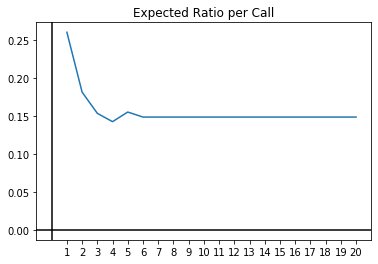

{'succ': 6, 'total_calls': 23, 'expected': 0.2608695652173913}
{'succ': 6, 'total_calls': 33, 'expected': 0.18181818181818182}
{'succ': 6, 'total_calls': 39, 'expected': 0.15384615384615385}
{'succ': 6, 'total_calls': 42, 'expected': 0.14285714285714285}
{'succ': 7, 'total_calls': 45, 'expected': 0.15555555555555556}
{'succ': 7, 'total_calls': 47, 'expected': 0.14893617021276595}
{'succ': 7, 'total_calls': 47, 'expected': 0.14893617021276595}
{'succ': 7, 'total_calls': 47, 'expected': 0.14893617021276595}
{'succ': 7, 'total_calls': 47, 'expected': 0.14893617021276595}
{'succ': 7, 'total_calls': 47, 'expected': 0.14893617021276595}
{'succ': 7, 'total_calls': 47, 'expected': 0.14893617021276595}
{'succ': 7, 'total_calls': 47, 'expected': 0.14893617021276595}
{'succ': 7, 'total_calls': 47, 'expected': 0.14893617021276595}
{'succ': 7, 'total_calls': 47, 'expected': 0.14893617021276595}
{'succ': 7, 'total_calls': 47, 'expected': 0.14893617021276595}
{'succ': 7, 'total_calls': 47, 'expected'

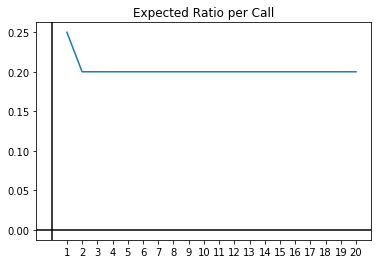

{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
Optimal Location is: 1
(('tertiary', 'unknown'), ('student'

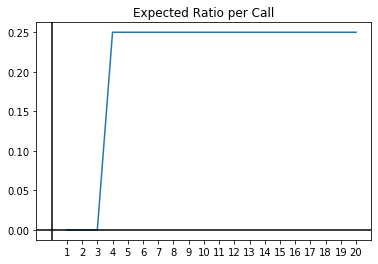

{'succ': 0, 'total_calls': 1, 'expected': 0.0}
{'succ': 0, 'total_calls': 2, 'expected': 0.0}
{'succ': 0, 'total_calls': 3, 'expected': 0.0}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 4, 'expected': 0.25}
Optimal Location is: 4
(('tertiary', 'unkno

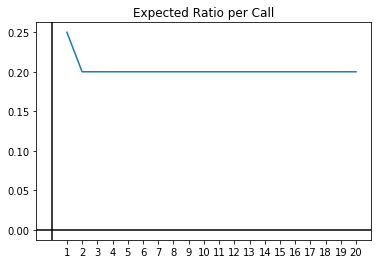

{'succ': 1, 'total_calls': 4, 'expected': 0.25}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
{'succ': 1, 'total_calls': 5, 'expected': 0.2}
Optimal Location is: 1
(('secondary', 'primary'), ('student

In [28]:
%%time

baseline_ov = []
opt_no_res_ov = []
opt_res_ov = []

train_df = mkt_df_filtered
test_df = mkt_df_filtered

# At this point, we can run computations for the success rate of each sub attribute and join
# the sub-attributes based on the output of k-means.
poss = []

# Education
all_ed = ['tertiary', 'secondary', 'primary', 'unknown']
metric_vals = compute_metric_for_each_attribute(all_ed, train_df, 'education')
education_cmbs = find_combinations(all_ed, metric_vals)

# Occupation
all_jobs = ['student', 'retired', 'unemployed', 'admin.', 'management', 'self-employed', 'technician', 'unknown', 'services', 'housemaid', 'blue-collar', 'entrepreneur']
metric_vals = compute_metric_for_each_attribute(all_jobs, train_df, 'job')
job_cmbs = find_combinations(all_jobs, metric_vals)

# Marital
all_ms = ['married', 'single', 'divorced', 'unknown']
metric_vals = compute_metric_for_each_attribute(all_ms, train_df, 'marital')
marital_cmbs = find_combinations(all_ms, metric_vals)

# Default
all_def = ['no', 'yes', 'unknown']
metric_vals = compute_metric_for_each_attribute(all_def, train_df, 'default')
default_cmbs = find_combinations(all_def, metric_vals)

# Loan
all_ln = ['no', 'yes', 'unknown']
metric_vals = compute_metric_for_each_attribute(all_ln, train_df, 'loan')
loan_cmbs = find_combinations(all_ln, metric_vals)

# Housing
all_hs = ['no', 'yes', 'unknown']
metric_vals = compute_metric_for_each_attribute(all_hs, train_df, 'housing')
housing_cmbs = find_combinations(all_hs, metric_vals)

poss.append(education_cmbs)
poss.append(marital_cmbs)
poss.append(job_cmbs)
poss.append(default_cmbs)
poss.append(loan_cmbs)
poss.append(housing_cmbs)
all_combs = list(itertools.product(*poss))

print("Number of combinations: ", len(all_combs)* len(age_query_strings) * len(balance_query_strings))

# We can now go ahead and genreate the feature sets based on what was done previously.

num_iter = 0
combs_to_consider = {}
# Setting up looping structures to generate all possibilities.
# All that has to be done now is to change 'df_train' to 'X_train'.
for age_query in age_query_strings:
    df_filtered_final = train_df.query(age_query)
    for bal_query in balance_query_strings:
        df_filtered_final_2 = df_filtered_final.query(bal_query)
        for comb in all_combs:
            dict_final_query = construct_dict(comb)
            num_iter += 1
            extracted_df = extract_rows_feature_set(df_filtered_final_2, dict_final_query)
            key = (dict_final_query['education'], dict_final_query['job'], dict_final_query['marital'], dict_final_query['default'], dict_final_query['loan'], dict_final_query['housing'], age_query, bal_query)
            n_rows = extracted_df.shape[0]
            if n_rows >0:
                results = compute_expected_succ_per_call_rate_feature_set(extracted_df, max_calls)
                max_loc = compute_optimal_call_no(results)
                if max_loc != -1:
                    combs_to_consider[key] = {'comb':comb, 'max_loc':max_loc + 1, 
                                              'best_rate':results[max_loc]['expected'], 
                                              'overall_rate':results[max_calls-1]['expected'], 
                                              'n_rows':n_rows, 'results':results}
                else:
                    print("Invalid FS !")

all_possible_calls = []

num_missed = 0

for loc, row in test_df.iterrows():
    # Preprocessing step for optimal method.
    # We have the exact values for each of the following:
    jb_query = convert(find_matching_attribute_comb(str(row['job']), job_cmbs))
    mt_query = convert(find_matching_attribute_comb(str(row['marital']), marital_cmbs))
    ec_query = convert(find_matching_attribute_comb(str(row['education']), education_cmbs))
    house_query = convert(find_matching_attribute_comb(str(row['housing']), housing_cmbs))
    loan_query = convert(find_matching_attribute_comb(str(row['loan']), loan_cmbs))
    def_query = convert(find_matching_attribute_comb(str(row['default']), default_cmbs))
    # These matches are different.
    bal_query = balance_query_strings[find_matching_attribute_eval_balance(int(row['balance']), 
                                                                           balance_query_format_strings)]
    age_query = age_query_strings[find_matching_attribute_eval_age(int(row['age']), 
                                                                   age_query_format_strings)]
    no_calls = row['campaign']
    key_to_find = (ec_query, jb_query, mt_query, def_query, loan_query, house_query, age_query, bal_query)
    if key_to_find in combs_to_consider.keys():
        fs = combs_to_consider[key_to_find]
        all_possible_calls.append((fs['best_rate'], fs['overall_rate'], row['y'], row['campaign'], 
                                   fs, key_to_find))
    else:
        num_missed += 1

# Optimal with restrictions on #calls for each feature set.
all_possible_calls_sorted_best = sorted(all_possible_calls, key = lambda tup: tup[0], reverse = True)
print("All Possible Calls: ", len(all_possible_calls))
print("All Possible Calls Best: ", len(all_possible_calls_sorted_best))
s_c_ratio_opt_res = []
num_calls = 0
num_succ = 0
num_bad = 0
saved = 0
prev_fs = all_possible_calls_sorted_best[0][5]
for index, item in enumerate(all_possible_calls_sorted_best[0:30]):
    user_outcome = item[2]
    user_calls = item[3]
    max_no_calls_fs = item[4]['max_loc']
    if user_calls >= 6:
        saved += 1
    if prev_fs != item[5]:
        curr_ratio = (div(num_succ, num_calls))
        s_c_ratio_opt_res.append((curr_ratio, num_calls))
        prev_fs = item[5]
        # For Checking Purposes ..
        ref = all_possible_calls_sorted_best[index - 1]
        results = ref[4]['results']
        plot_graph_new(results, max_calls, False, "Expected Ratio per Call")
        for r in results:
            print(r)
        print("Optimal Location is:", ref[4]['max_loc'])
        print(item[5])
        print("At call number: ", num_calls)
        print("Ratio for current fs:", curr_ratio)
        print("\n\n")
    if user_outcome == "yes" and user_calls <= max_no_calls_fs:
        num_succ += 1
        num_calls += user_calls
    elif user_outcome == "yes" and user_calls > max_no_calls_fs:
        num_calls += max_no_calls_fs
        num_bad += 1
    elif user_outcome == "no" and user_calls <= max_no_calls_fs:
        num_calls += user_calls
    elif user_outcome == "no" and user_calls > max_no_calls_fs:
        num_calls += max_no_calls_fs
    print("\n---\n")
    print("Curr No Of Calls: ", num_calls)
    print("Curr No Of Succ: ", num_succ)
    print("FS is:", item[5])
    print("This user #calls was:", user_calls)
    print("Outcome of user was:", user_outcome)
    print("\n--\n\n")
s_c_ratio_opt_res.append((div(num_succ, num_calls), num_calls))

print("Potentially Bad: ", num_bad)
print("Saved excessive calls: ", saved)